In [1]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import numpy as np
import warnings
import requests
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Function to connect and query Wikimedia Cloud database
def connect_and_query(wiki_name, query, cnf_path="/home/paws/.my.cnf"):
    conn = pymysql.connect(
        host=wiki_name + '.analytics.db.svc.wikimedia.cloud',
        read_default_file=cnf_path,
        database=wiki_name + '_p'
    )
    
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
    
    conn.close()
    return data

In [4]:
wikis = ['tewiki', 'hiwiki', 'mlwiki']
all_dfs = []

<h3>Average size of an edit by edit count bucket</h3>

In [5]:
query_url = "https://raw.githubusercontent.com/Ziyaur-Rahaman/community-insights-dashboard-tooling/refs/heads/branch1/avg_size_of_edit.sql"
query1 = requests.get(query_url).text

In [6]:
query1

"SELECT\n  CASE\n    WHEN user_edits.edit_count BETWEEN 1 AND 10 THEN '1–10'\n    WHEN user_edits.edit_count BETWEEN 11 AND 50 THEN '11–50'\n    WHEN user_edits.edit_count BETWEEN 51 AND 100 THEN '51–100'\n    WHEN user_edits.edit_count BETWEEN 101 AND 500 THEN '101–500'\n    WHEN user_edits.edit_count BETWEEN 501 AND 1000 THEN '501–1000'\n    ELSE '1001+'\n  END AS edit_count_bucket,\n  AVG(ABS(CAST(r.rev_len AS SIGNED) - CAST(p.rev_len AS SIGNED))) AS avg_edit_size\nFROM revision r\nJOIN revision p ON r.rev_parent_id = p.rev_id\nJOIN (\n  SELECT rev_actor, COUNT(*) AS edit_count   # number of edits done by user\n  FROM revision\n  GROUP BY rev_actor\n) AS user_edits ON r.rev_actor = user_edits.rev_actor\nGROUP BY edit_count_bucket\n;\n"

In [7]:
def run_violin_data(wikis, query):
    all_data = []
    for wiki in wikis:
        result = connect_and_query(wiki, query)
        df = pd.DataFrame(result, columns=['edit_count_bucket', 'edit_size'])
        df['wiki'] = wiki
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

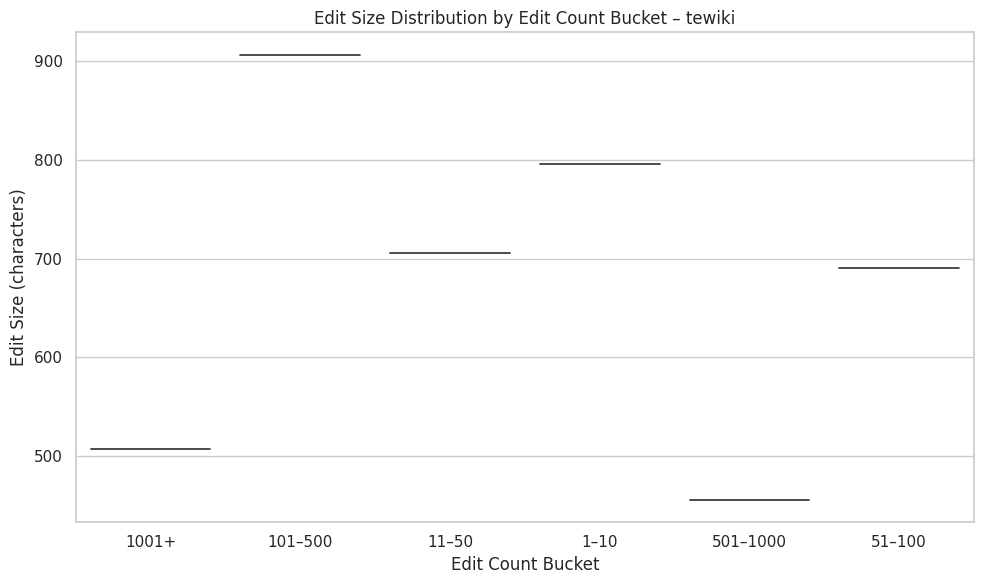

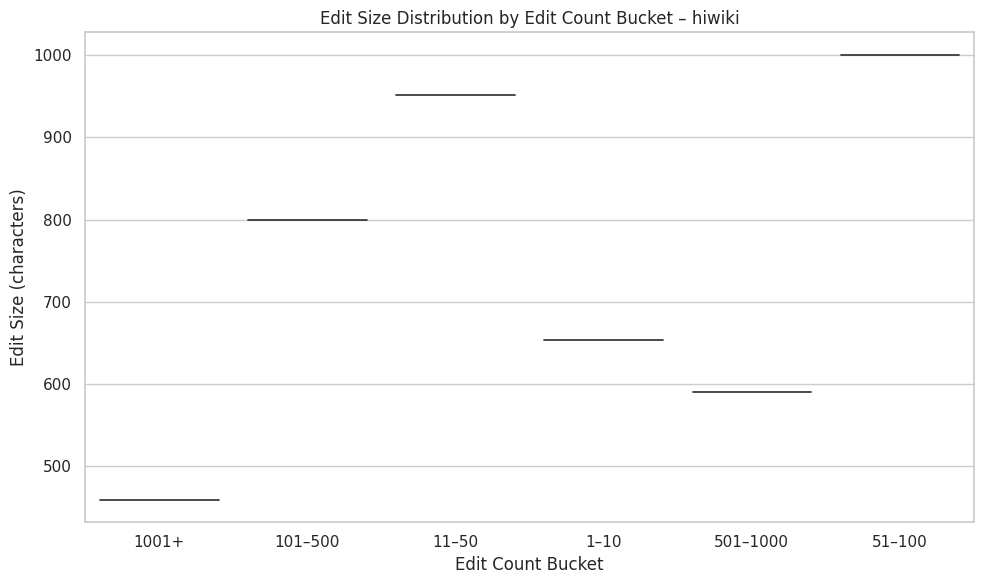

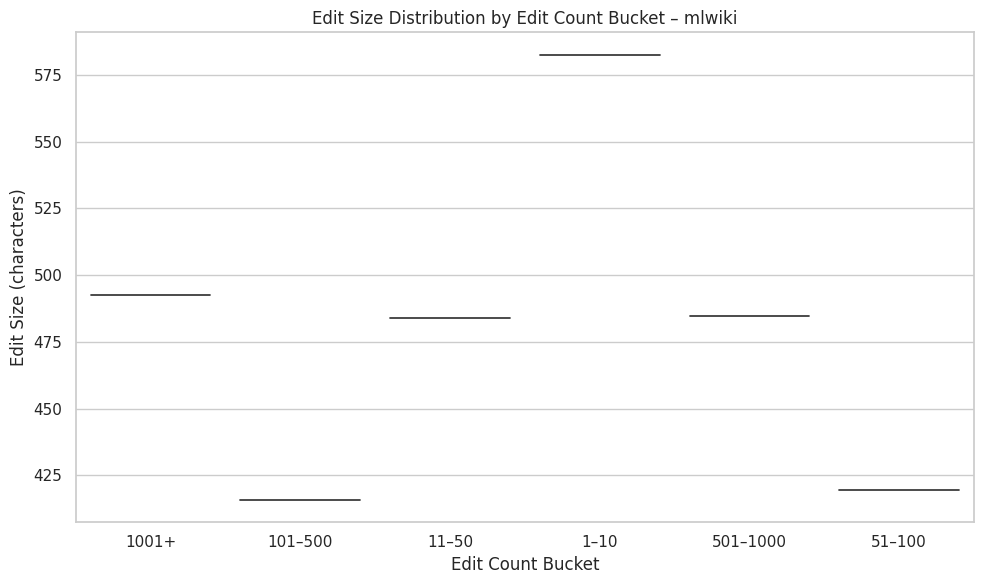

In [8]:
edit_data = run_violin_data(wikis, query1)

sns.set(style="whitegrid")

for wiki in edit_data['wiki'].unique():
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=edit_data[edit_data['wiki'] == wiki],
                   x='edit_count_bucket',
                   y='edit_size',
                   inner='quartile',
                   palette='viridis')
    
    plt.title(f'Edit Size Distribution by Edit Count Bucket – {wiki}')
    plt.xlabel('Edit Count Bucket')
    plt.ylabel('Edit Size (characters)')
    plt.tight_layout()
    plt.show()

<h3>Monthly edits on talk pages </h3>

In [13]:
query_url = "https://raw.githubusercontent.com/Ziyaur-Rahaman/community-insights-dashboard-tooling/refs/heads/branch1/Monthly_edits_on_talk_pages.sql"

query_talk_activity = requests.get(query_url).text

In [14]:
def run_query_for_wikis(wikis, query):
    results = []
    for wiki in wikis:
        output = connect_and_query(wiki, query)
        df = pd.DataFrame(output, columns=["year", "month", "talk_page_type", "edit_count"])
        df['wiki'] = wiki
        results.append(df)
    return pd.concat(results, ignore_index=True)

In [15]:

combined_df = run_query_for_wikis(wikis, query_talk_activity)


In [16]:
# Convert columns to correct types
combined_df['year'] = combined_df['year'].astype(int)
combined_df['month'] = combined_df['month'].astype(int)
combined_df['edit_count'] = combined_df['edit_count'].astype(int)
combined_df['date'] = pd.to_datetime(combined_df[['year', 'month']].assign(day=1))


<Figure size 1400x700 with 0 Axes>

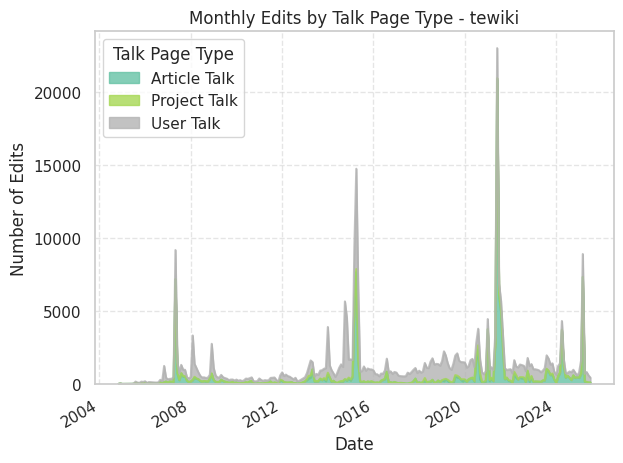

<Figure size 1400x700 with 0 Axes>

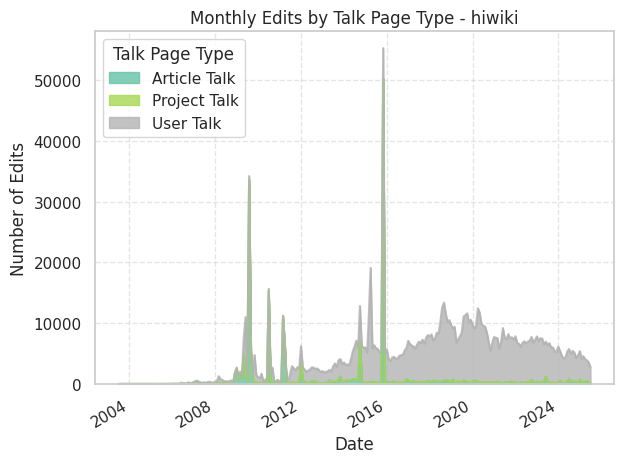

<Figure size 1400x700 with 0 Axes>

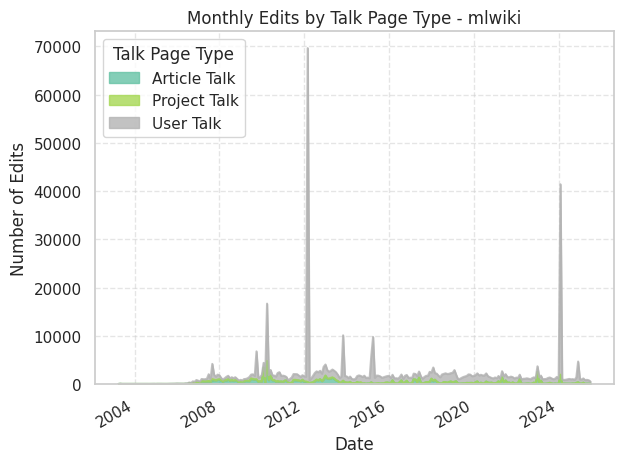

In [18]:

# stacked area plot for each wiki
for wiki in combined_df['wiki'].unique():
    temp = combined_df[combined_df['wiki'] == wiki]
    
    # Pivot for stacked plot
    pivot_df = temp.pivot(index="date", columns="talk_page_type", values="edit_count").fillna(0)
    pivot_df.sort_index(inplace=True)
    
    # Plot
    plt.figure(figsize=(14, 7))
    pivot_df.plot(kind='area', stacked=True, colormap='Set2', alpha=0.8)
    plt.title(f"Monthly Edits by Talk Page Type - {wiki}")
    plt.xlabel("Date")
    plt.ylabel("Number of Edits")
    plt.legend(title="Talk Page Type", loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

<h3>number of pages that were never edited after creation</h3>

In [19]:
query_url = "https://raw.githubusercontent.com/Ziyaur-Rahaman/community-insights-dashboard-tooling/refs/heads/branch1/number_of_pages_that_were_never_edited_after_creation.sql"

query = requests.get(query_url).text

In [20]:
def run_page_edit_query(wikis, query):
    results = []
    for wiki in wikis:
        data = connect_and_query(wiki, query)
        count = data[0][0] if data else 0
        results.append({'wiki': wiki, 'no_of_unedited_pages': count})
    return pd.DataFrame(results)


In [21]:
df_unedited = run_page_edit_query(wikis, query)


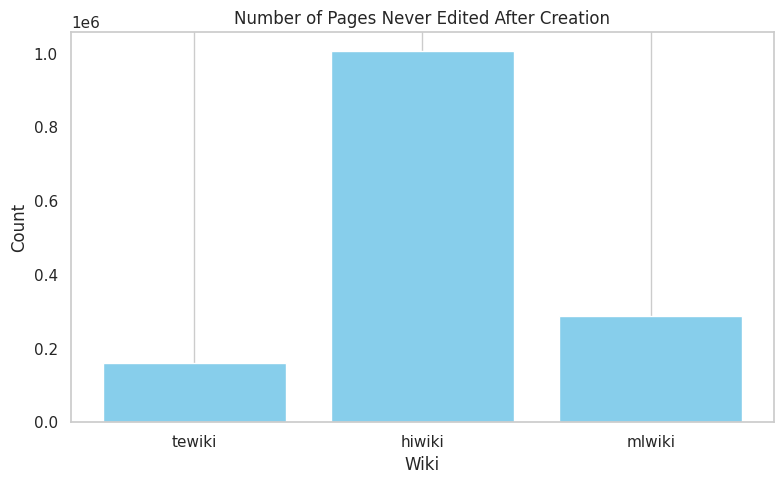

In [22]:
plt.figure(figsize=(8,5))
plt.bar(df_unedited['wiki'], df_unedited['no_of_unedited_pages'], color='skyblue')
plt.title('Number of Pages Never Edited After Creation')
plt.xlabel('Wiki')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()